In [1]:
## Load packages
using Pkg
using JLD
using Eirene
using Combinatorics
using SparseArrays
using Plots
using LightGraphs
using GraphPlot
using MAT
using Distances
using Glob
using LinearAlgebra
using DelimitedFiles
using JLD

┌ Info: Recompiling stale cache file /root/.julia/compiled/v1.2/Eirene/mCiG1.ji for Eirene [9c0f25c4-2ca1-5870-89f6-52640788da1d]
└ @ Base loading.jl:1240
┌ Warning: Package Eirene does not have Pkg in its dependencies:
│ - If you have Eirene checked out for development and have
│   added Pkg as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Eirene
└ Loading Pkg into Eirene from project dependency, future warnings for Eirene are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5053516599138742517\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4518655396490503947\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5053516599138742517\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
function createSimplexLists(incidenceMatrix,simplex_named_list)
    
    # Will make lists of edges, 2-simplices, and 3-simplices
    edge_list = Any[]
    simp2_list = Any[]
    simp3_list = Any[]
    
    for (index,simplex_name) in enumerate(simplex_named_list)

        indices_of_simplex_nodes = findall(incidenceMatrix[index,:].>0)

        edges_from_simplex = collect(combinations(indices_of_simplex_nodes,2))
        simp2_from_simplex = collect(combinations(indices_of_simplex_nodes,3))
        simp3_from_simplex = collect(combinations(indices_of_simplex_nodes,4))
    

        for (index2,edge) in enumerate(edges_from_simplex)
            push!(edge_list,edge)
        end
        for (index2,simp2) in enumerate(simp2_from_simplex)
            push!(simp2_list,simp2)
        end
        for (index2,simp3) in enumerate(simp3_from_simplex)
            push!(simp3_list,simp3)
        end
    end
    edge_list = unique(edge_list)
    simp2_list = unique(simp2_list)
    simp3_list = unique(simp3_list)
    
    
    
    return edge_list, simp2_list, simp3_list
end


function createCellList(nNodes,edgeList,keepTriangles)
    n2Simps = length(keepTriangles)
    nEdges = length(edgeList)
    #E = Array{Array{Float64}}((Int(nNodes+nEdges+n2Simps)),1)
    E = Array{Array{Float64,1},1}(undef,Int(nNodes+nEdges+n2Simps))
    nCells = length(E)
    for a0 in collect(1:nCells)

        if a0 <= nNodes
            E[a0] = [a0]
        elseif a0 > (nNodes) && a0<=(nNodes+nEdges)
            E[a0] = edgeList[a0-nNodes]
        else
            E[a0] = keepTriangles[a0-(nNodes+nEdges)]

        end

    end
    E
end
        
function createDMatrix(E,nNodes,nEdges)
    D_01 = Int.(issubset.(E[1:nNodes],E[(nNodes+1):(nNodes+nEdges)]'))
    D_12 = Int.(issubset.(E[(nNodes+1):(nNodes+nEdges)],E[(nNodes+nEdges+1):length(E)]'))
    D = zeros(length(E),length(E))
    D[1:nNodes,(nNodes+1):(nNodes+nEdges)] = D_01
    D[(nNodes+1):(nNodes+nEdges),(nNodes+nEdges+1):length(E)] = D_12
    D = sparse(D)
end
        
function determineCellWeight(cell)
    cellWeight = maximum(node_weights[Int.(cell)])
end

        
function bettiCurveFromBarcode(barcode1,nSteps,weights,rev)

    bettiCurve = zeros(nSteps+1,1)
    ordered_weights = sort(unique(weights))
    if rev == true
        ordered_weights = reverse(ordered_weights)
    end
    for bar in collect(1:size(barcode1)[1])
        birth_index = Int(findall(ordered_weights.==barcode1[bar,1])[1])

        if barcode1[bar,2]>maximum(ordered_weights)

            bettiCurve[birth_index:Int(nSteps+1),1] = bettiCurve[birth_index:Int(nSteps+1),1] .+1
        else

            death_index = Int(findall(ordered_weights.==barcode1[bar,2])[1])
            bettiCurve[birth_index:death_index,1] = bettiCurve[birth_index:death_index,1].+1

        end
    end

    return bettiCurve
end
        
            
function plotBarcode(barcode,nSteps)

    nSteps = Int(nSteps)
    pbar = plot(1:2,zeros(2,1),c=:black)

    barcode_sorted = barcode[sortperm(barcode[:,1]),:]
    nbars = size(barcode)[1]


    for bar_index in collect(1:nbars)
        birth = barcode[bar_index,1]
        death = barcode[bar_index,2]
        if death>nSteps
            death = nSteps+1
        end

        plot!([birth, death],[bar_index, bar_index],c=:blue, legend = false,
                            xlim = (0,nSteps))
    end


    return pbar
end
            
function plotPersistenceDiagram(barcode1, nSteps, weights, rev)
    
    ordered_weights = sort(unique(weights))
    if rev == true
        ordered_weights = reverse(ordered_weights)
    end
                
    h = plot(0:maximum(weights), 0:maximum(weights), palette = :grays)
    for bar in collect(1:size(barcode1)[1])
        birth_index = Int(findall(ordered_weights.==barcode1[bar,1])[1])

        if barcode1[bar,2]>maximum(ordered_weights)
            
            scatter!([birth_index],[length(ordered_weights)], xlim = (0,1000),
                                    ylim = (0,1000), aspect_ratio = :equal, legend = false)

            #bettiCurve[birth_index:Int(nSteps+1),1] = bettiCurve[birth_index:Int(nSteps+1),1] .+1
        else

            death_index = Int(findall(ordered_weights.==barcode1[bar,2])[1])
            scatter!([birth_index],[death_index], xlim = (0,1000),
                                    ylim = (0,1000), aspect_ratio = :equal, legend = false)
        end
    end
                    
    return h
end

plotPersistenceDiagram (generic function with 1 method)

  Building GR → `~/.julia/packages/GR/oiZD3/deps/build.log`


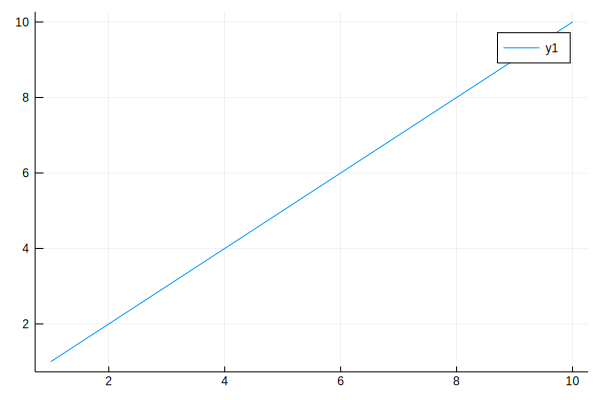

In [3]:
ENV["GRDIR"]=""
Pkg.build("GR")
plot([1:1:10])

In [5]:
file = matopen("/mnt/d/Emmanuel/PerFish/CorrMatrices_control_fix.mat")
data_WT=read(file, "CorrMatrics_control") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
size(data_WT)

(21, 10, 90, 90)

In [4]:
file = matopen("/mnt/d/Emmanuel/PerFish/CorrMatrices_fmr1_fix.mat")
data_FMR=read(file, "CorrMatrices") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
size(data_FMR)

(21, 11, 90, 90)

In [65]:
file = matopen("/mnt/d/Emmanuel/PerFish/CorrMatrices_het_minusFish.mat")
data_het=read(file, "CorrMatrices") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
size(data_het)

(21, 20, 90, 90)

In [10]:
file = matopen("/mnt/d/Emmanuel/PerFish/CorrMatrices_control_minusFish.mat")
data_WT=read(file, "CorrMatrices") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
size(data_WT)

(21, 10, 90, 90)

In [5]:
list_PH_FMR=Array{Any}(undef,3,size(data_FMR)[2],size(data_FMR)[3])
counter=1
for idx_loom in [2 6 12]
    for idx_fish in range(1,stop=size(data_FMR)[2])
        for idx_node in range(1,stop=size(data_FMR)[3])
            C = eirene(LinearAlgebra.Symmetric(data_FMR[idx_loom,idx_fish,1:end .!= idx_node,1:end .!= idx_node]), model = "vr", maxdim=2)
            list_PH_FMR[counter,idx_fish,idx_node]=C
        end
    end
    counter=counter+1
end

UndefVarError: UndefVarError: data_FMR not defined

In [6]:
list_PH_WT=Array{Any}(undef,3,size(data_WT)[2],size(data_WT)[3])
counter=1
for idx_loom in [2 6 12]
    for idx_fish in range(1,stop=size(data_WT)[2])
        for idx_node in range(1,stop=size(data_WT)[3])
            C = eirene(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,1:end .!= idx_node,1:end .!= idx_node]), model = "vr", maxdim=2)
            list_PH_WT[counter,idx_fish,idx_node]=C
        end
    end
    counter=counter+1
end

UndefVarError: UndefVarError: data_WT not defined

In [15]:
save("PH_WT_Loom1_5_11_perNode.jld", "list_PH_WT", list_PH_WT)
save("PH_FMR_Loom1_5_11_perNode.jld", "list_PH_FMR", list_PH_FMR)

In [27]:
idx_loom=2;idx_fish=1;idx_node=1;counter=1;
edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_fish,idx_node,1:end .!= idx_node,1:end .!= idx_node]))))
			nEdgeWeights = length(edge_weights)
			barcode_data = barcode(list_PH_WT[counter,idx_fish,idx_node],dim=0) 
size(barcode_data)[1]>2
bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false) 

true

In [35]:
LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,idx_node,1:end .!= idx_node,1:end .!= idx_node])

DimensionMismatch: DimensionMismatch("matrix is not square: dimensions are (89, 0)")

In [43]:
if size(barcode_data)[1]>2
				bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false) 
				FMRtoPlot[counter,idx_fish,idx_node,1]=cumsum(bettiCurve_1,dims=1)[end]
				barcode_data = barcode(list_PH_FMR[counter,idx_fish,idx_node],dim=1)            
				bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
				FMRtoPlot[counter,idx_fish,idx_node,2]=cumsum(bettiCurve_1,dims=1)[end]
				barcode_data = barcode(list_PH_FMR[counter,idx_fish,idx_node],dim=2)            
				bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
end

3892×1 Array{Float64,2}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [36]:
WTtoPlot=Array{Float64}(undef,3,size(data_WT)[2],size(data_WT)[3],3)
counter=1
for idx_loom in [2 6 12]
    for idx_fish in range(1,stop=size(list_PH_WT)[2])
        for idx_node in range(1,stop=size(list_PH_WT)[3])            
			#print(string(idx_loom) * " fish : " * string(idx_fish))
			edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,1:end .!= idx_node,1:end .!= idx_node]))))
			nEdgeWeights = length(edge_weights)
			barcode_data = barcode(list_PH_WT[counter,idx_fish,idx_node],dim=0)        
			if size(barcode_data)[1]>2
				bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false) 
				WTtoPlot[counter,idx_fish,idx_node,1]=cumsum(bettiCurve_1,dims=1)[end]
				barcode_data = barcode(list_PH_WT[counter,idx_fish,idx_node],dim=1)            
				bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
				WTtoPlot[counter,idx_fish,idx_node,2]=cumsum(bettiCurve_1,dims=1)[end]
				barcode_data = barcode(list_PH_WT[counter,idx_fish,idx_node],dim=2)            
				bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
				WTtoPlot[counter,idx_fish,idx_node,3]=cumsum(bettiCurve_1,dims=1)[end]
			end
		end
    end
	counter=counter+1
end

In [ ]:
FMRtoPlot=Array{Float64}(undef,3,size(data_FMR)[2],size(data_FMR)[3],3)
counter=1
for idx_loom in [2 6 12]
    for idx_fish in range(1,stop=size(data_FMR)[2])
        for idx_node in range(1,stop=size(data_FMR)[3])
			#print(string(idx_loom) * " fish : " * string(idx_fish) * " node : " * string(idx_node) * " ")
			edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_FMR[idx_loom,idx_fish,1:end .!= idx_node,1:end .!= idx_node]))))
			nEdgeWeights = length(edge_weights)
			barcode_data = barcode(list_PH_FMR[counter,idx_fish,idx_node],dim=0) 
            todelete=Any[]
            if size(barcode_data)[1]>2
                for i in range(1,stop=size(barcode_data)[1])
                    if isnan(barcode_data[i,1])
                        append!(todelete,i)
                    end
                end
            end
            barcode_data=barcode_data[setdiff(1:end,todelete),:]
			if size(barcode_data)[1]>2
				bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false) 
				FMRtoPlot[counter,idx_fish,idx_node,1]=cumsum(bettiCurve_1,dims=1)[end]
				barcode_data = barcode(list_PH_FMR[counter,idx_fish,idx_node],dim=1)  
                todelete=Any[]
            if size(barcode_data)[1]>2
                for i in range(1,stop=size(barcode_data)[1])
                    if isnan(barcode_data[i,1])
                        append!(todelete,i)
                    end
                end
            end
            barcode_data=barcode_data[setdiff(1:end,todelete),:]
				bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
				FMRtoPlot[counter,idx_fish,idx_node,2]=cumsum(bettiCurve_1,dims=1)[end]
				barcode_data = barcode(list_PH_FMR[counter,idx_fish,idx_node],dim=2)       
                todelete=Any[]
            if size(barcode_data)[1]>2
                for i in range(1,stop=size(barcode_data)[1])
                    if isnan(barcode_data[i,1])
                        append!(todelete,i)
                    end
                end
            end
            barcode_data=barcode_data[setdiff(1:end,todelete),:]
				bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
				FMRtoPlot[counter,idx_fish,idx_node,3]=cumsum(bettiCurve_1,dims=1)[end]
			end
		end
    end
	counter=counter+1
end

In [51]:
writedlm( "/mnt/d/Emmanuel/PerFish/WT_loom1_dim0.csv",  WTtoPlot[1,:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_loom1_dim1.csv",  WTtoPlot[1,:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_loom1_dim2.csv",  WTtoPlot[1,:,:,3], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_loom5_dim0.csv",  WTtoPlot[2,:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_loom5_dim1.csv",  WTtoPlot[2,:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_loom5_dim2.csv",  WTtoPlot[2,:,:,3], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_loom11_dim0.csv",  WTtoPlot[3,:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_loom11_dim1.csv",  WTtoPlot[3,:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_loom11_dim2.csv",  WTtoPlot[3,:,:,3], ',')

In [52]:
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_loom1_dim0.csv",  FMRtoPlot[1,:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_loom1_dim1.csv",  FMRtoPlot[1,:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_loom1_dim2.csv",  FMRtoPlot[1,:,:,3], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_loom5_dim0.csv",  FMRtoPlot[2,:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_loom5_dim1.csv",  FMRtoPlot[2,:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_loom5_dim2.csv",  FMRtoPlot[2,:,:,3], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_loom11_dim0.csv",  FMRtoPlot[3,:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_loom11_dim1.csv",  FMRtoPlot[3,:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_loom11_dim2.csv",  FMRtoPlot[3,:,:,3], ',')

In [ ]:
list_PH_WT=Array{Any}(undef,size(data_WT)[1],size(data_WT)[2])
for idx_loom in range(1,stop=size(data_WT)[1])
    for idx_fish in range(1,stop=size(data_WT)[2])
        C = eirene(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,:,:]), model = "vr", maxdim=3)
        list_PH_WT[idx_loom,idx_fish]=C
    end
end

In [ ]:
list_PH_FMR=Array{Any}(undef,size(data_FMR)[1],size(data_FMR)[2])
for idx_loom in range(1,stop=size(data_FMR)[1])
    for idx_fish in range(1,stop=size(data_FMR)[2])
        C = eirene(LinearAlgebra.Symmetric(data_FMR[idx_loom,idx_fish,:,:]), model = "vr", maxdim=3)
        list_PH_FMR[idx_loom,idx_fish]=C
    end
end

In [ ]:
save("PH_WT_Loom1_21_perFish.jld", "list_PH_WT", list_PH_WT)
save("PH_FMR_Loom1_21_perFish.jld", "list_PH_FMR", list_PH_FMR)

In [8]:
list_PH_het=Array{Any}(undef,size(data_het)[1],size(data_het)[2])
for idx_loom in range(1,stop=size(data_het)[1])
    for idx_fish in range(1,stop=size(data_het)[2])
        C = eirene(LinearAlgebra.Symmetric(data_het[idx_loom,idx_fish,:,:]), model = "vr", maxdim=3)
        list_PH_het[idx_loom,idx_fish]=C
    end
end

UndefVarError: UndefVarError: data_het not defined

In [7]:
WTtoPlot=Array{Float64}(undef,size(data_WT)[1],size(data_WT)[2],4000)
WTtoPlot_sum=Array{Float64}(undef,size(data_WT)[1],size(data_WT)[2],4000)
for idx_loom in range(1,stop=size(data_WT)[1])    
    for idx_fish in range(1,stop=size(data_WT)[2])        
        edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)               
        barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=1)            
        bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
        WTtoPlot[idx_loom,idx_fish,:]=bettiCurve_1[1:4000]
        WTtoPlot_sum[idx_loom,idx_fish,:]=cumsum(bettiCurve_1,dims=1)[1:4000]        
    end
end

In [11]:
i=0;1+i*size(data_WT)[2]:1+size(data_WT)[2]+i*size(data_WT)[2]

1:11

In [17]:
Temp=Array{Float64}(undef,11*size(data_WT)[2],4000)
Temp2=Array{Float64}(undef,11*size(data_WT)[2],4000)
for i in range(0,stop=10)
    Temp[1+i*size(data_WT)[2]:size(data_WT)[2]+i*size(data_WT)[2],:]=WTtoPlot[i+2,:,:]
    Temp2[1+i*size(data_WT)[2]:size(data_WT)[2]+i*size(data_WT)[2],:]=WTtoPlot_sum[i+2,:,:]
end

In [13]:
size(Temp)

(110, 4000)

In [18]:
writedlm( "/mnt/d/Emmanuel/PerFish/WT_Betti_dim1.csv",  Temp, ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_BettiSum_dim1.csv",  Temp2, ',')

In [69]:
WTtoPlot=Array{Float64}(undef,size(data_WT)[1],size(data_WT)[2],3)
for idx_loom in range(1,stop=size(data_WT)[1])    
    for idx_fish in range(1,stop=size(data_WT)[2])
        #print(string(idx_loom) * " fish : " * string(idx_fish))
        edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=0)        
        if size(barcode_data)[1]>2
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false) 
            WTtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=1)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=2)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,3]=cumsum(bettiCurve_1,dims=1)[end]
        end
    end
end

In [70]:
FMRtoPlot=Array{Float64}(undef,size(data_FMR)[1],size(data_FMR)[2],3)
for idx_loom in range(1,stop=size(data_FMR)[1])    
    for idx_fish in range(1,stop=size(data_FMR)[2])
        #print(string(idx_loom) * " fish : " * string(idx_fish))
        edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_FMR[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=0)        
        if size(barcode_data)[1]>2
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false) 
            FMRtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=1)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            FMRtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=2)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            FMRtoPlot[idx_loom,idx_fish,3]=cumsum(bettiCurve_1,dims=1)[end]
        end
    end
end

In [71]:
hettoPlot=Array{Float64}(undef,size(data_het)[1],size(data_het)[2],3)
for idx_loom in range(1,stop=size(data_het)[1])    
    for idx_fish in range(1,stop=size(data_het)[2])
        #print(string(idx_loom) * " fish : " * string(idx_fish))
        edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_het[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(list_PH_het[idx_loom,idx_fish],dim=0)        
        if size(barcode_data)[1]>2
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false) 
            hettoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_het[idx_loom,idx_fish],dim=1)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            hettoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_het[idx_loom,idx_fish],dim=2)            
            bettiCurve_1 = bettiCurveFromBarcode((barcode_data),nEdgeWeights,edge_weights,false)       
            hettoPlot[idx_loom,idx_fish,3]=cumsum(bettiCurve_1,dims=1)[end]
        end
    end
end

In [ ]:
WTtoPlot=Array{Float64}(undef,size(data_WT)[1],size(data_WT)[2],3)
for idx_loom in range(1,stop=size(data_WT)[1])    
    for idx_fish in range(1,stop=size(data_WT)[2])
        #print(string(idx_loom) * " fish : " * string(idx_fish))
        edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=0)
        todelete=Any[]
        if size(barcode_data)[1]>2
            for i in range(1,stop=size(barcode_data)[1])
                if isnan(barcode_data[i,1])
                    append!(todelete,i)
                end
            end
        end
        barcode_data=barcode_data[setdiff(1:end,todelete),:]
        if size(barcode_data)[1]>2
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=1)
            todelete=Any[]
            if size(barcode_data)[1]>2
                for i in range(1,stop=size(barcode_data)[1])
                    if isnan(barcode_data[i,1])
                        append!(todelete,i)
                    end
                end
            end
            barcode_data=barcode_data[setdiff(1:end,todelete),:]
            bettiCurve_1 = bettiCurveFromBarcode(barcode(barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=2)
            todelete=Any[]
            if size(barcode_data)[1]>2
                for i in range(1,stop=size(barcode_data)[1])
                    if isnan(barcode_data[i,1])
                        append!(todelete,i)
                    end
                end
            end
            barcode_data=barcode_data[setdiff(1:end,todelete),:]
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,3]=cumsum(bettiCurve_1,dims=1)[end]
        end
    end
end

In [ ]:
FMRtoPlot=Array{Float64}(undef,size(data_FMR)[1],size(data_FMR)[2],3)
for idx_loom in range(1,stop=size(data_FMR)[1])    
    for idx_fish in range(1,stop=size(data_FMR)[2])
        #print(string(idx_loom) * " fish : " * string(idx_fish))
        edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_FMR[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=0)
        todelete=Any[]
        if size(barcode_data)[1]>2
            for i in range(1,stop=size(barcode_data)[1])
                if isnan(barcode_data[i,1])
                  WTtoPlot=Array{Float64}(undef,size(data_WT)[1],size(data_WT)[2],3)
for idx_loom in range(1,stop=size(data_WT)[1])    
    for idx_fish in range(1,stop=size(data_WT)[2])
        #print(string(idx_loom) * " fish : " * string(idx_fish))
        edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=0)
        todelete=Any[]
        if size(barcode_data)[1]>2
            for i in range(1,stop=size(barcode_data)[1])
                if isnan(barcode_data[i,1])
                    append!(todelete,i)
                end
            end
        end
        barcode_data=barcode_data[setdiff(1:end,todelete),:]
        if size(barcode_data)[1]>2
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false)      
            WTtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=1)
            todelete=Any[]
            if size(barcode_data)[1]>2
                for i in range(1,stop=size(barcode_data)[1])
                    if isnan(barcode_data[i,1])
                        append!(todelete,i)
                    end
                end
            end
            barcode_data=barcode_data[setdiff(1:end,todelete),:]
            bettiCurve_1 = bettiCurveFromBarcode(barcode(barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=2)
            todelete=Any[]
            if size(barcode_data)[1]>2
                for i in range(1,stop=size(barcode_data)[1])
                    if isnan(barcode_data[i,1])
                        append!(todelete,i)
                    end
                end
            end
            barcode_data=barcode_data[setdiff(1:end,todelete),:]
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data),nEdgeWeights,edge_weights,false)       
            WTtoPlot[idx_loom,idx_fish,3]=cumsum(bettiCurve_1,dims=1)[end]
        end
    end
end  append!(todelete,i)
                end
            end
        end
        barcode_data=barcode_data[setdiff(1:end,todelete),:]
        if size(barcode_data)[1]>2
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data[1:end-1,:],nEdgeWeights,edge_weights,false)       
            FMRtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false)       
            barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=1)
            todelete=Any[]
            if size(barcode_data)[1]>2
                for i in range(1,stop=size(barcode_data)[1])
                    if isnan(barcode_data[i,1])
                        append!(todelete,i)
                    end
                end
            end
            barcode_data=barcode_data[setdiff(1:end,todelete),:]
            FMRtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]
            barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=2)
            todelete=Any[]
            if size(barcode_data)[1]>2
                for i in range(1,stop=size(barcode_data)[1])
                    if isnan(barcode_data[i,1])
                        append!(todelete,i)
                    end
                end
            end
            barcode_data=barcode_data[setdiff(1:end,todelete),:]
            bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false)       
            FMRtoPlot[idx_loom,idx_fish,3]=cumsum(bettiCurve_1,dims=1)[end]
        end
    end
end

In [72]:
writedlm( "/mnt/d/Emmanuel/PerFish/WT_full_dim0.csv",  WTtoPlot[:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_full_dim1.csv",  WTtoPlot[:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_full_dim2.csv",  WTtoPlot[:,:,3], ',')

In [75]:
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_full_dim0.csv",  FMRtoPlot[:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_full_dim1.csv",  FMRtoPlot[:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_full_dim2.csv",  FMRtoPlot[:,:,3], ',')

In [74]:
writedlm( "/mnt/d/Emmanuel/PerFish/het_full_dim0.csv",  hettoPlot[:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/het_full_dim1.csv",  hettoPlot[:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/het_full_dim2.csv",  hettoPlot[:,:,3], ',')

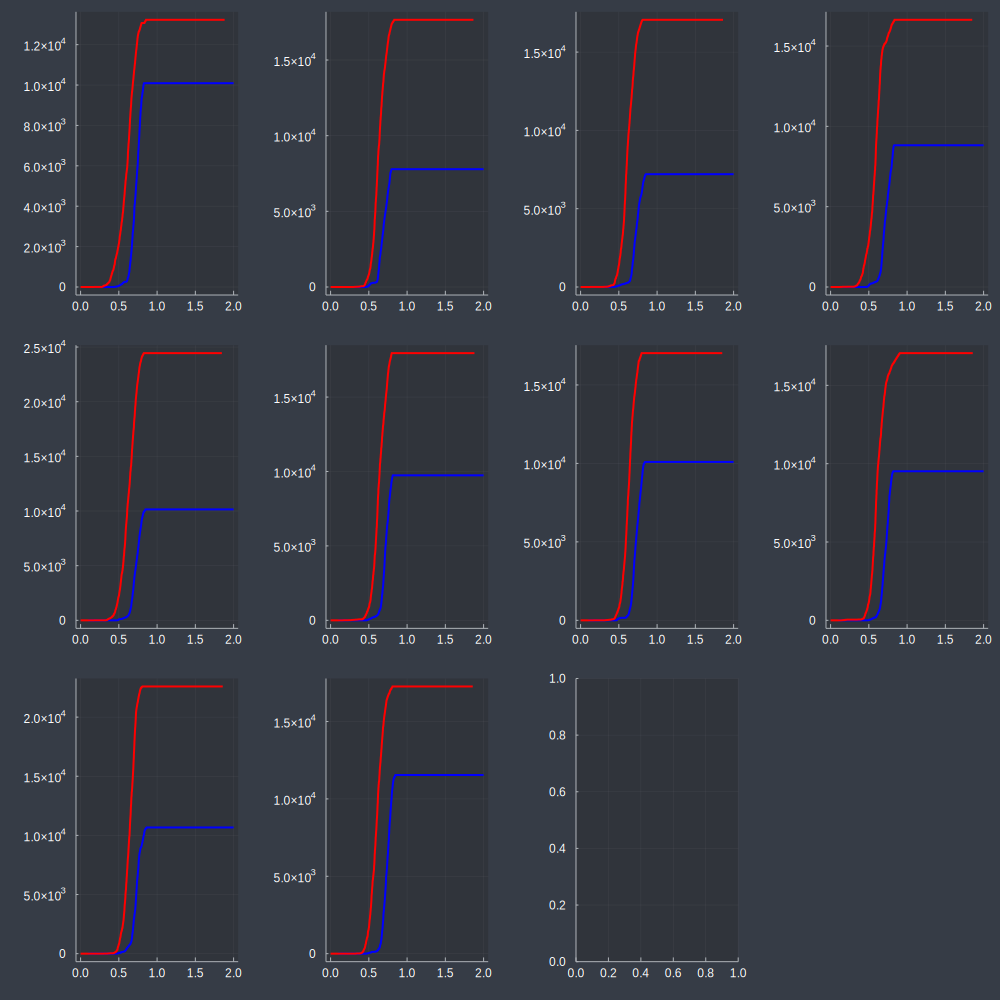

In [38]:
p2a=plot(layout=11,size=(1000,1000))
idx_loom=11
for idx_fish in range(1,stop=size(data_WT)[2])
    edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,:,:]))))
    nEdgeWeights = length(edge_weights)
    barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=1)
    bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
    plot!([edge_weights; 2],cumsum(bettiCurve_1,dims=1), c=:blue,subplot=idx_fish, linewidth = 2,legend=false)
    
    edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_FMR[idx_loom,idx_fish,:,:]))))
    nEdgeWeights = length(edge_weights)
    barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=1)
    bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false)
    plot!([edge_weights; 2],cumsum(bettiCurve_1,dims=1), c=:red,subplot=idx_fish, linewidth = 2,legend=false)    
end
p2a

In [41]:
p2a=plot(layout=11,size=(1000,1000))
idx_loom=2
for idx_fish in range(1,stop=size(data_WT)[2])
    edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,:,:]))))
    nEdgeWeights = length(edge_weights)
    barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=3)
    bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
    plot!([edge_weights; 2],cumsum(bettiCurve_1,dims=1), c=:blue,subplot=idx_fish, linewidth = 2,legend=false)
    
    edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_FMR[idx_loom,idx_fish,:,:]))))
    nEdgeWeights = length(edge_weights)
    barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=3)
    bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false)
    plot!([edge_weights; 2],cumsum(bettiCurve_1,dims=1), c=:red,subplot=idx_fish, linewidth = 2,legend=false)    
end
p2a

BoundsError: BoundsError: attempt to access 0-element Array{Int64,1} at index [1]

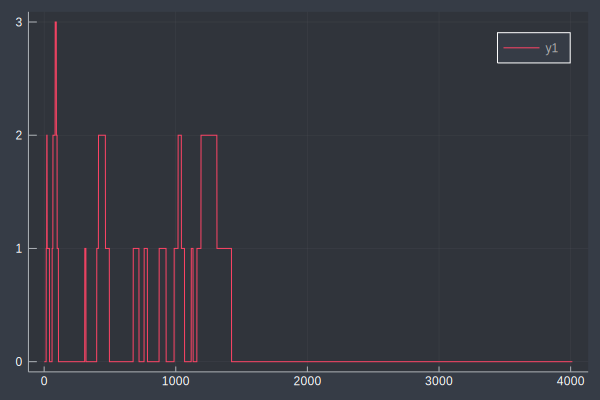

In [53]:
edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,:,:]))))
nEdgeWeights = length(edge_weights)
barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=1)
bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
plot(bettiCurve_1)

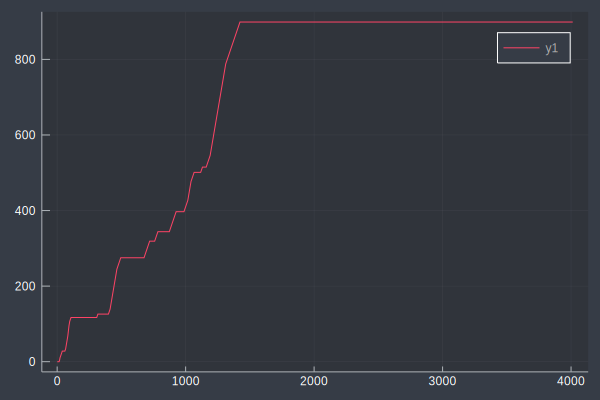

In [52]:
plot(cumsum(bettiCurve_1,dims=1))

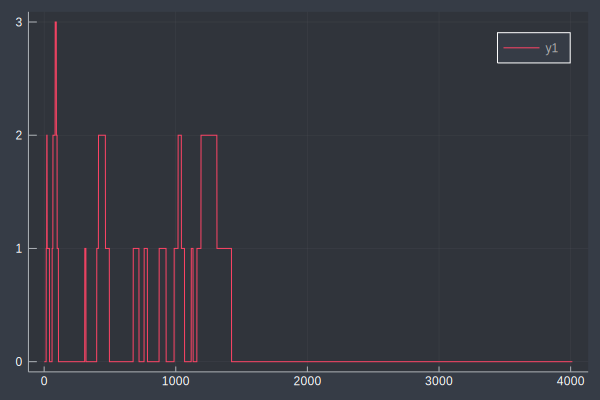

In [51]:
plot(cumsum(bettiCurve_1,dims=2))

In [ ]:
WTtoPlot=Array{Float64}(undef,size(data_WT)[1],size(data_WT)[2],2)
FMRtoPlot=Array{Float64}(undef,size(data_FMR)[1],size(data_FMR)[2],2)
for idx_loom in range(1,stop=21)    
    for idx_fish in range(1,stop=size(data_WT)[2])
        edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_WT[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=1)
        bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
        WTtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]
        barcode_data = barcode(list_PH_WT[idx_loom,idx_fish],dim=2)
        bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
        WTtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]
        edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_FMR[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=1)
        bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false)
        FMRtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]   
        barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=2)
        bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false)
        FMRtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]       
    end
end

In [ ]:
idx_fish=12
for idx_loom in range(1,stop=21)   
    edge_weights = sort(unique(Iterators.flatten(LinearAlgebra.Symmetric(data_FMR[idx_loom,idx_fish,:,:]))))
        nEdgeWeights = length(edge_weights)
        barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=1)
        bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false)
        FMRtoPlot[idx_loom,idx_fish,1]=cumsum(bettiCurve_1,dims=1)[end]   
        barcode_data = barcode(list_PH_FMR[idx_loom,idx_fish],dim=2)
        bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false)
        FMRtoPlot[idx_loom,idx_fish,2]=cumsum(bettiCurve_1,dims=1)[end]   
end

In [ ]:
writedlm( "/mnt/d/Emmanuel/PerFish/WT_full_dim1c.csv",  WTtoPlot[:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/WT_full_dim2c.csv",  WTtoPlot[:,:,2], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_full_dim1c.csv",  FMRtoPlot[:,:,1], ',')
writedlm( "/mnt/d/Emmanuel/PerFish/FMR_full_dim2c.csv",  FMRtoPlot[:,:,2], ',')

In [54]:
file = matopen("/mnt/d/Emmanuel/PerFish/Minimal_wired.mat")
data_min=read(file, "Minimal_wired") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
size(data_min)

(90, 90)

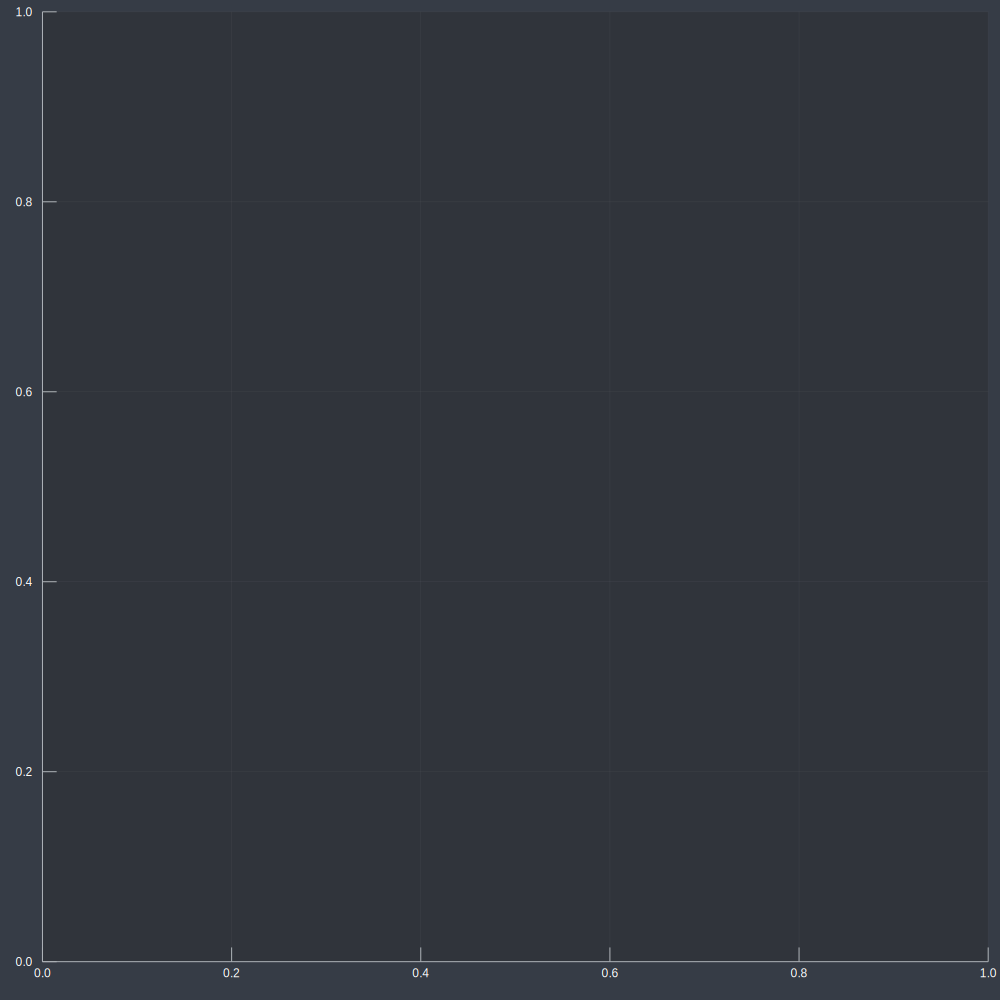

In [56]:
C_min = eirene(data_min, model = "vr", maxdim=3)


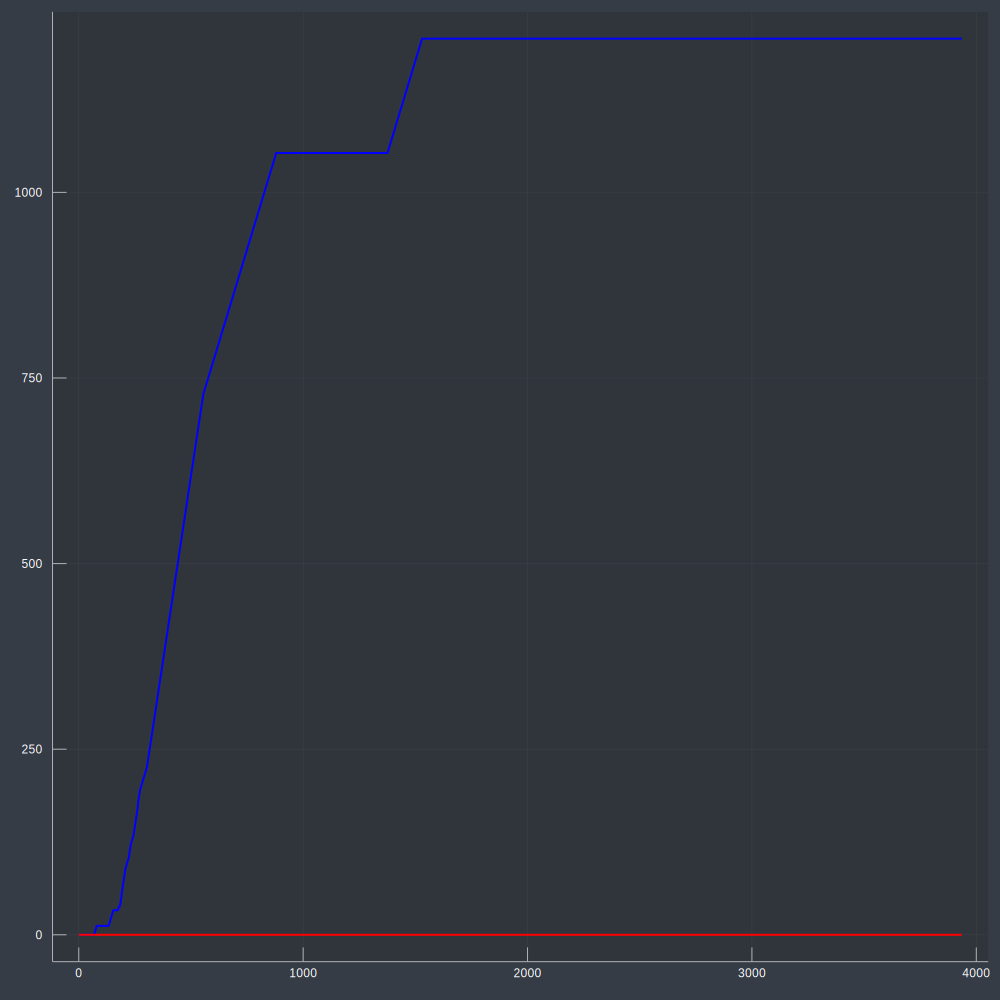

In [60]:
p2a=plot(size=(1000,1000))
edge_weights = sort(unique(Iterators.flatten(data_min)))
nEdgeWeights = length(edge_weights)
barcode_data = barcode(C_min,dim=1)
bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
plot!(cumsum(bettiCurve_1,dims=1), c=:blue,subplot=idx_fish, linewidth = 2,legend=false)        
barcode_data = barcode(C_min,dim=2)
bettiCurve_1 = bettiCurveFromBarcode(barcode_data,nEdgeWeights,edge_weights,false) 
plot!(cumsum(bettiCurve_1,dims=1), c=:red,subplot=idx_fish, linewidth = 2,legend=false)        
p2a

In [ ]:
size(data_WT)[2]

In [ ]:
todelete=Any[]
for i in range(1,stop=size(barcode_data)[1])
    if isnan(barcode_data[i,1])
        append!(todelete,i)
    end
end
todelete

In [ ]:
cleanbarcode=barcode_data[setdiff(1:end,todelete),:]

In [6]:
plot([1:1:10])

ErrorException: error compiling _plot!: error compiling _display: could not load library "libGR.so"
libGR.so: cannot open shared object file: No such file or directory

In [ ]:
function plotBarcode_sorted(barcode_data,edge_weights)
    edge_idx = sortperm(edge_weights)
    nbars = size(barcode_data)[1]
    pbar = plot(1:2,zeros(2,1),c=:black)
    nSteps = length(edge_weights)
    barcode_sorted = barcode_data[sortperm(barcode_data[:,1]),:]

    for bar_index in collect(1:nbars)
        birth = edge_idx[findall(edge_weights.==barcode_sorted[bar_index,1])]
        birth=birth[1]
        death = edge_idx[findall(edge_weights.==barcode_sorted[bar_index,2])]
        death=death[1]

        plot!(birth:death,ones(Float16,(death-birth+1))*bar_index, legend = false, xticks = (edge_idx[1:250:4000],round.(edge_weights[edge_idx[1:250:4000]],digits=4)),
                            rotation=-45,xlim = (0,2500))
    end


    return pbar
end

In [ ]:
p2a=plot(layout=21,size=(1000,1000))

for idx_loom in range(1,stop=size(data_WT)[1])
    file = matopen(file_list_wt[idx_file])
    data=read(file, "CorrMatrix") # note that this does NOT introduce a variable ``varname`` into scope
    close(file)
    edge_weights = sort(unique(Iterators.flatten(data)))
    nEdgeWeights = length(edge_weights)
    bettiCurve_1 = bettiCurveFromBarcode(barcode(list_PH_WT[split(split(file_list[idx_file],"_")[end],".mat")[1]],dim=0)[1:end-1,:],nEdgeWeights,edge_weights,false)       
    plot!(cumsum(bettiCurve_1,dims=1), c=:blue, linewidth = 2,subplot=idx_file,legend=false)
    
    file = matopen(file_list_fmr[idx_file])
    data=read(file, "CorrMatrix") # note that this does NOT introduce a variable ``varname`` into scope
    close(file)
    edge_weights = sort(unique(Iterators.flatten(data)))
    nEdgeWeights = length(edge_weights)
    bettiCurve_1 = bettiCurveFromBarcode(barcode(list_PH_FMR[split(split(file_list[idx_file],"_")[end],".mat")[1]],dim=0)[1:end-1,:],nEdgeWeights,edge_weights,false)       
    plot!(cumsum(bettiCurve_1,dims=1), c=:red, linewidth = 2,subplot=idx_file,legend=false,title=string(idx_file))
end
p2a

In [ ]:
p2a=plot(layout=21,size=(1000,1000))
# Calculate Betti_1 from the barcode output
file_list_fmr=glob("*fmr*.mat","/mnt/d/Emmanuel")
file_list_wt=glob("*control*.mat","/mnt/d/Emmanuel")
for idx_file in range(1,stop=length(file_list))
    file = matopen(file_list_wt[idx_file])
    data=read(file, "CorrMatrix") # note that this does NOT introduce a variable ``varname`` into scope
    close(file)
    edge_weights = sort(unique(Iterators.flatten(data)))
    nEdgeWeights = length(edge_weights)
    bettiCurve_1 = bettiCurveFromBarcode(barcode(list_PH_WT[split(split(file_list[idx_file],"_")[end],".mat")[1]],dim=0)[1:end-1,:],nEdgeWeights,edge_weights,false)       
    plot!(cumsum(bettiCurve_1,dims=1), c=:blue, linewidth = 2,subplot=idx_file,legend=false)
    
    file = matopen(file_list_fmr[idx_file])
    data=read(file, "CorrMatrix") # note that this does NOT introduce a variable ``varname`` into scope
    close(file)
    edge_weights = sort(unique(Iterators.flatten(data)))
    nEdgeWeights = length(edge_weights)
    bettiCurve_1 = bettiCurveFromBarcode(barcode(list_PH_FMR[split(split(file_list[idx_file],"_")[end],".mat")[1]],dim=0)[1:end-1,:],nEdgeWeights,edge_weights,false)       
    plot!(cumsum(bettiCurve_1,dims=1), c=:red, linewidth = 2,subplot=idx_file,legend=false,title=string(idx_file))
end
p2a

In [ ]:
p2a=plot(layout=21,size=(1000,1000))
# Calculate Betti_1 from the barcode output
file_list_fmr=glob("*fmr*.mat","/mnt/d/Emmanuel")
file_list_wt=glob("*control*.mat","/mnt/d/Emmanuel")
for idx_file in range(1,stop=length(file_list))
    file = matopen(file_list_wt[idx_file])
    data=read(file, "CorrMatrix") # note that this does NOT introduce a variable ``varname`` into scope
    close(file)
    edge_weights = sort(unique(Iterators.flatten(data)))
    nEdgeWeights = length(edge_weights)
    bettiCurve_1 = bettiCurveFromBarcode(barcode(list_PH_WT[split(split(file_list[idx_file],"_")[end],".mat")[1]],dim=1),nEdgeWeights,edge_weights,false)       
    plot!(cumsum(bettiCurve_1,dims=1), c=:blue, linewidth = 2,subplot=idx_file,legend=false)
    
    file = matopen(file_list_fmr[idx_file])
    data=read(file, "CorrMatrix") # note that this does NOT introduce a variable ``varname`` into scope
    close(file)
    edge_weights = sort(unique(Iterators.flatten(data)))
    nEdgeWeights = length(edge_weights)
    bettiCurve_1 = bettiCurveFromBarcode(barcode(list_PH_FMR[split(split(file_list[idx_file],"_")[end],".mat")[1]],dim=1),nEdgeWeights,edge_weights,false)       
    plot!(cumsum(bettiCurve_1,dims=1), c=:red, linewidth = 2,subplot=idx_file,legend=false,title=string(idx_file))
end
p2a

In [4]:
p2a=plot(layout=6,size=(1000,1000))
# Calculate Betti_1 from the barcode output
file_list_fmr=glob("*fmr*.mat","/mnt/d/Emmanuel")
file_list_wt=glob("*control*.mat","/mnt/d/Emmanuel")
for idx_file in [2 6 12]
    file = matopen(file_list_wt[idx_file])
    data=read(file, "CorrMatrix") # note that this does NOT introduce a variable ``varname`` into scope
    close(file)
    edge_weights = sort(unique(Iterators.flatten(data)))
    nEdgeWeights = length(edge_weights)
    bettiCurve_1 = bettiCurveFromBarcode(barcode(list_PH_WT[split(split(file_list_wt[idx_file],"_")[end],".mat")[1]],dim=2),nEdgeWeights,edge_weights,false)       
    plot!(cumsum(bettiCurve_1,dims=1), c=:blue, linewidth = 2,subplot=idx_file,legend=false)
    
    file = matopen(file_list_fmr[idx_file])
    data=read(file, "CorrMatrix") # note that this does NOT introduce a variable ``varname`` into scope
    close(file)
    edge_weights = sort(unique(Iterators.flatten(data)))
    nEdgeWeights = length(edge_weights)
    bettiCurve_1 = bettiCurveFromBarcode(barcode(list_PH_FMR[split(split(file_list[idx_file],"_")[end],".mat")[1]],dim=2),nEdgeWeights,edge_weights,false)       
    plot!(cumsum(bettiCurve_1,dims=1), c=:red, linewidth = 2,subplot=idx_file,legend=false,title=string(idx_file))
end
p2a

UndefVarError: UndefVarError: file_list not defined

In [ ]:
file = matopen("/mnt/d/Temp/wt_corr_mean_fix.mat")
data=read(file, "wt_corrmatrix_mean") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

# View an individual brain and the average
p1a = heatmap(data, aspect_ratio = :equal)
xlabel!("Regions")
title!("Individual scan")

In [ ]:
file = matopen("/mnt/d/Temp/fmr1_corr_mean3_fix.mat")
data2=read(file, "fmr1_corrmatrix_mean3") # note that this does NOT introduce a variable ``varname`` into scope
close(file)
# View an individual brain and the average
p1a = heatmap(data2, aspect_ratio = :equal)
xlabel!("Regions")
title!("Individual scan")

In [ ]:
C = eirene(data, model = "vr", maxdim=3)

C

In [ ]:
# Calculate Betti_1 from the barcode output
edge_weights = sort(unique(Iterators.flatten(data)))
nEdgeWeights = length(edge_weights)
bettiCurve_1 = bettiCurveFromBarcode(barcode(C,dim=1),
    nEdgeWeights,edge_weights,false)
bettiCurve_2 = bettiCurveFromBarcode(barcode(C,dim=2),
    nEdgeWeights,edge_weights,false)
bettiCurve_3 = bettiCurveFromBarcode(barcode(C,dim=3),
    nEdgeWeights,edge_weights,false)

# Plot!
p2a = plot(1:(nEdgeWeights+1),bettiCurve_1, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights+1), bettiCurve_2, c=:red,linewidth = 2, lab = "B_2")
plot!(1:(nEdgeWeights+1), bettiCurve_3, c=:green,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
C2 = eirene(data2, model = "vr", maxdim=3)

println("Finished running persistent homology!")

In [ ]:
# Calculate Betti_1 from the barcode output
edge_weights2 = sort(unique(Iterators.flatten(data2)))
nEdgeWeights2 = length(edge_weights2)

bettiCurve_1b = bettiCurveFromBarcode(barcode(C2,dim=1),
    nEdgeWeights2,edge_weights2,false)
bettiCurve_2b = bettiCurveFromBarcode(barcode(C2,dim=2),
    nEdgeWeights2,edge_weights2,false)
bettiCurve_3b = bettiCurveFromBarcode(barcode(C2,dim=3),
    nEdgeWeights2,edge_weights2,false)

# Plot!
p2a = plot(1:(nEdgeWeights2+1),bettiCurve_1b, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights2+1), bettiCurve_2b, c=:red,linewidth = 2, lab = "B_2")
plot!(1:(nEdgeWeights2+1), bettiCurve_3b, c=:green,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
# Plot!
p2a = plot(1:(nEdgeWeights+1),bettiCurve_1, c=:blue, linewidth = 2, lab = "WT dim1")
plot!(1:(nEdgeWeights2+1), bettiCurve_1b, c=:red,linewidth = 2, lab = "FMR dim1")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
# Plot!
p2a = plot(1:(nEdgeWeights+1),bettiCurve_2, c=:blue, linewidth = 2, lab = "WT dim2")
plot!(1:(nEdgeWeights2+1), bettiCurve_2b, c=:red,linewidth = 2, lab = "FMR dim2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
p2a = plot(1:(nEdgeWeights+1),bettiCurve_1, c=:blue, linewidth = 2, lab = "WT dim1")
plot!(1:(nEdgeWeights2+1), bettiCurve_1b, c=:red,linewidth = 2, lab = "FMR dim1")
p2b = plot(1:(nEdgeWeights+1),bettiCurve_2, c=:blue, linewidth = 2, lab = "WT dim2")
plot!(1:(nEdgeWeights2+1), bettiCurve_2b, c=:red,linewidth = 2, lab = "FMR dim2")
plot(p2a,p2b,layout=(2,1), size=(1000,500))
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
C = eirene(data[1:97,1:97], model = "vr", maxdim=3)
C2 = eirene(data2[1:97,1:97], model = "vr", maxdim=3)
# Calculate Betti_1 from the barcode output
edge_weights = sort(unique(Iterators.flatten(data[1:97,1:97])))
nEdgeWeights = length(edge_weights)
bettiCurve_1 = bettiCurveFromBarcode(barcode(C,dim=1),
    nEdgeWeights,edge_weights,false)
bettiCurve_2 = bettiCurveFromBarcode(barcode(C,dim=2),
    nEdgeWeights,edge_weights,false)

edge_weights2 = sort(unique(Iterators.flatten(data2[1:97,1:97])))
nEdgeWeights2 = length(edge_weights2)

bettiCurve_1b = bettiCurveFromBarcode(barcode(C2,dim=1),
    nEdgeWeights2,edge_weights2,false)
bettiCurve_2b = bettiCurveFromBarcode(barcode(C2,dim=2),
    nEdgeWeights2,edge_weights2,false)

# Plot!
p2a = plot(1:(nEdgeWeights+1),bettiCurve_1, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights2+1), bettiCurve_1b, c=:red,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
# Calculate Betti_1 from the barcode output
edge_weights2 = sort(unique(Iterators.flatten(data2[2:99,2:99])))
nEdgeWeights2 = length(edge_weights2)

In [ ]:
# Plot!
p2a = plot(1:(nEdgeWeights+1),bettiCurve_2, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights2+1), bettiCurve_2b, c=:red,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
function plotBarcode2(barcode_data,edge_weights)
    edge_idx = sortperm(edge_weights)
    nbars = size(barcode_data)[1]
    pbar = plot(1:2,zeros(2,1),c=:black)
    nSteps = length(edge_weights)
    

    for bar_index in collect(1:nbars)
        birth = edge_idx[findall(edge_weights.==barcode_data[bar_index,1])]
        birth=birth[1]
        death = edge_idx[findall(edge_weights.==barcode_data[bar_index,2])]
        death=death[1]

        plot!(birth:death,ones(Float16,(death-birth+1))*bar_index, legend = false,
                            xlim = (0,nSteps))
    end


    return pbar
end

In [ ]:
plotBarcode2(barcode(C,dim=1),edge_weights)

In [ ]:
plotBarcode2(barcode(C2,dim=1),edge_weights2)

In [ ]:
function plotBarcode_sorted(barcode_data,edge_weights)
    edge_idx = sortperm(edge_weights)
    nbars = size(barcode_data)[1]
    pbar = plot(1:2,zeros(2,1),c=:black)
    nSteps = length(edge_weights)
    barcode_sorted = barcode_data[sortperm(barcode_data[:,1]),:]

    for bar_index in collect(1:nbars)
        birth = edge_idx[findall(edge_weights.==barcode_sorted[bar_index,1])]
        birth=birth[1]
        death = edge_idx[findall(edge_weights.==barcode_sorted[bar_index,2])]
        death=death[1]

        plot!(birth:death,ones(Float16,(death-birth+1))*bar_index, legend = false, xticks = (edge_idx[1:250:4000],round.(edge_weights[edge_idx[1:250:4000]],digits=4)),
                            rotation=-45,xlim = (0,2500))
    end


    return pbar
end

In [ ]:
barcode(C,dim=1)

In [ ]:
plotBarcode_sorted(barcode(C2,dim=1),edge_weights2)

In [ ]:
test=barcode(C,dim=1)

In [ ]:
edge_idx = sortperm(edge_weights)
findall(edge_weights.==test[1,1])

In [ ]:
edge_weights[2]

In [ ]:
temp=data.-2
temp=temp.*-1
temp2=data2.-2
temp2=temp2.*-1

In [ ]:
using LinearAlgebra

In [ ]:
temp[diagind(temp)] .= 0
temp2[diagind(temp2)] .= 0

In [ ]:
C = eirene(temp, model = "vr", maxdim=3)
# Calculate Betti_1 from the barcode output
edge_weights = sort(unique(Iterators.flatten(temp)))
nEdgeWeights = length(edge_weights)
bettiCurve_1 = bettiCurveFromBarcode(barcode(C,dim=1),
    nEdgeWeights,edge_weights,false)
bettiCurve_2 = bettiCurveFromBarcode(barcode(C,dim=2),
    nEdgeWeights,edge_weights,false)

# Plot!
p2a = plot(1:(nEdgeWeights+1),bettiCurve_1, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights+1), bettiCurve_2, c=:red,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
C = eirene(temp, model = "vr", maxdim=3)
C2 = eirene(temp2, model = "vr", maxdim=3)
# Calculate Betti_1 from the barcode output
edge_weights2 = sort(unique(Iterators.flatten(temp2)))
nEdgeWeights2 = length(edge_weights2)
bettiCurve_1b = bettiCurveFromBarcode(barcode(C2,dim=1),
    nEdgeWeights2,edge_weights2,false)
bettiCurve_2b = bettiCurveFromBarcode(barcode(C2,dim=2),
    nEdgeWeights2,edge_weights2,false)

# Plot!
p2a = plot(1:(nEdgeWeights+1),bettiCurve_1, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights2+1), bettiCurve_1b, c=:red,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
# Plot!
p2a = plot(1:(nEdgeWeights+1),bettiCurve_2, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights2+1), bettiCurve_2b, c=:red,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
bettiCurve_3 = bettiCurveFromBarcode(barcode(C,dim=3),
    nEdgeWeights,edge_weights,false)
bettiCurve_3b = bettiCurveFromBarcode(barcode(C2,dim=3),
    nEdgeWeights2,edge_weights2,false)

# Plot!

p2a = plot(1:(nEdgeWeights+1),bettiCurve_3, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights2+1), bettiCurve_3b, c=:red,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
# Plot!
p2a = plot(1:(nEdgeWeights+1),bettiCurve_2, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights2+1), bettiCurve_2b, c=:red,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")

In [ ]:
plotBarcode_sorted(barcode(C,dim=1),edge_weights)

In [ ]:
plotBarcode_sorted(barcode(C2,dim=1),edge_weights2)

In [ ]:
data[1,1]

In [ ]:
size(data)

In [ ]:
data_fixed=vcat(data,temp[1:99]')

In [ ]:
data_fixed_neg=hcat(vcat(temp,ones(Float16,99)' .* 1000),ones(Float16,100)*1000)
data_fixed_neg[100,1:99].=0
data_fixed_neg[1:99,100].=0
data_fixed_neg

In [ ]:
data_fixed_neg[diagind(data_fixed_neg)] .= 0
C_fixed_neg = eirene(data_fixed_neg, model = "vr", maxdim = 3)
barcode(C_fixed_neg,dim=1)   # I expect this output to contain actual barcodes

In [ ]:
data_fixed=hcat(vcat(data,ones(Float16,99)' .* 1000),ones(Float16,100)*1000)
data_fixed[100,100]=0
data_fixed

In [ ]:
C_fixed = eirene(data_fixed, model = "vr", maxdim = 3)
barcode(C_fixed,dim=1)   # I expect this output to contain actual barcodes

In [ ]:
using DelimitedFiles

In [ ]:
C

In [ ]:
function NodeContribution_outputbarcodes(distanceMatrix,filename::String)    
    # Will compute euclidean distance between bettiCurves of full data vs data - 1 node
          
    C = eirene(distanceMatrix, model = "vr", maxdim=2)    
    
    barcode_1 = barcode(C,dim=1)
    barcode_2 = barcode(C,dim=2)    
    
    writedlm( filename * "full_dim1.csv",  barcode_1, ' ')
    writedlm( filename * "full_dim2.csv",  barcode_2, ' ')
    
    for index in range(1,stop=size(distanceMatrix)[1])
        C_miss = eirene(distanceMatrix[1:end .!= index,1:end .!= index], model = "vr", maxdim=2)
        
        barcode_1 = barcode(C_miss,dim=1)
        barcode_2 = barcode(C_miss,dim=2)    
    
        writedlm( filename * "miss_" * string(index) * "_dim1.csv",  barcode_1, ' ')
        writedlm( filename * "miss_" * string(index) * "_dim2.csv",  barcode_2, ' ')
        
    end        
end


In [ ]:
NodeContribution_outputbarcodes(data,"WT_")
NodeContribution_outputbarcodes(data2,"fmr_")

In [ ]:
function NodeContribution(distanceMatrix)    
    # Will compute euclidean distance between bettiCurves of full data vs data - 1 node
    
    distanceList = zeros(size(distanceMatrix)[1],2)
    
    C = eirene(distanceMatrix, model = "vr", maxdim=2)
    edge_weights = sort(unique(Iterators.flatten(distanceMatrix)))
    nEdgeWeights = length(edge_weights)
    bettiCurve_1 = bettiCurveFromBarcode(barcode(C,dim=1),nEdgeWeights,edge_weights,false)
    bettiCurve_2 = bettiCurveFromBarcode(barcode(C,dim=2),nEdgeWeights,edge_weights,false)
    
    for index in range(1,stop=size(distanceMatrix)[1])
        C_miss = eirene(distanceMatrix[1:end .!= index,1:end .!= index], model = "vr", maxdim=2)
        edge_weights = sort(unique(Iterators.flatten(distanceMatrix[1:end .!= index,1:end .!= index])))
        nEdgeWeights = length(edge_weights)
        bettiCurve_1_miss = bettiCurveFromBarcode(barcode(C_miss,dim=1),nEdgeWeights,edge_weights,false)
        bettiCurve_2_miss = bettiCurveFromBarcode(barcode(C_miss,dim=2),nEdgeWeights,edge_weights,false)
        distanceList[index,1]=norm(bettiCurve_1[1:length(bettiCurve_1_miss)]-bettiCurve_1_miss)
        distanceList[index,2]=norm(bettiCurve_2[1:length(bettiCurve_2_miss)]-bettiCurve_2_miss)
    end    
    return distanceList
end

In [ ]:
Euclid_WT=NodeContribution(data)

In [ ]:
plot(Euclid_WT[:,1], c=:blue, linewidth = 2, lab = "Euclid Dist Dim 1 WT")
plot!(Euclid_WT[:,2], c=:red, linewidth = 2, lab = "Euclid Dist Dim 2 WT")

In [ ]:
Euclid_FMR=NodeContribution(data2)

In [ ]:
plot(Euclid_FMR[:,1], c=:blue, linewidth = 2, lab = "Euclid Dist Dim 1 FMR")
plot!(Euclid_FMR[:,2], c=:red, linewidth = 2, lab = "Euclid Dist Dim 2 FMR")

In [ ]:
findmax(Euclid_FMR[:,1])

In [ ]:
findmax(Euclid_FMR[:,2])

In [ ]:
p2a = plot(Euclid_WT[:,1], c=:blue, linewidth = 2, lab = "WT dim1")
plot!(Euclid_FMR[:,1], c=:red,linewidth = 2, lab = "FMR dim1")
title!("Node contribution to PH")
p2b = plot(Euclid_WT[:,2], c=:blue, linewidth = 2, lab = "WT dim2")
plot!(Euclid_FMR[:,2], c=:red,linewidth = 2, lab = "FMR dim2")
xlabel!("ID of removed node")
plot(p2a,p2b,layout=(2,1), size=(1000,500))
ylabel!("Euclidean distance")


In [ ]:
file = matopen("/mnt/d/Temp/Nod_coord.mat")
data_min=read(file, "Nod_coord") # note that this does NOT introduce a variable ``varname`` into scope
close(file)

# View an individual brain and the average
p1a = heatmap(data_min, aspect_ratio = :equal)
xlabel!("Regions")
title!("Individual scan")

In [ ]:
C3 = eirene(data_min, model = "vr", maxdim=3)
# Calculate Betti_1 from the barcode output
edge_weights3 = sort(unique(Iterators.flatten(data_min)))
nEdgeWeights3 = length(edge_weights3)

bettiCurve_1c = bettiCurveFromBarcode(barcode(C3,dim=1),
    nEdgeWeights3,edge_weights3,false)
bettiCurve_2c = bettiCurveFromBarcode(barcode(C3,dim=2),
    nEdgeWeights3,edge_weights3,false)
bettiCurve_3c = bettiCurveFromBarcode(barcode(C3,dim=3),
    nEdgeWeights3,edge_weights3,false)

# Plot!
p2a = plot(1:(nEdgeWeights3+1),bettiCurve_1c, c=:blue, linewidth = 2, lab = "B_1")
plot!(1:(nEdgeWeights3+1), bettiCurve_2c, c=:red,linewidth = 2, lab = "B_2")
xlabel!("Edges added")
ylabel!("Betti_k")
title!("Betti curves")